#**Extreme Gradient Boosting (XGBoost) Model**

* Project: Retail Sales Forecasting
* Model: Extreme Gradient Boosting (XGBoost)
* Date: January 2026

##Objectives

1. Pre-process data for XGBoost model requirements
2. Prepare train/test splits for time series validation
3. Set up and configure XGBoost model with appropriate parameters
4. Train the model and generate forecasts
5. Evaluate model performance with multiple metric



**Step 1: Import Libraries and Load Data**

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

# Load the cleaned daily sales data
df = pd.read_csv('/content/drive/MyDrive/final_cleaned_sales_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Load raw external files
# This file serves as our primary source of truth for all historical shocks,
# including the 2016 Earthquake (Terremoto Manabi).
holidays = pd.read_csv('/content/drive/MyDrive/holidays_events.csv')
holidays['date'] = pd.to_datetime(holidays['date'])

# Reset index for merging and inspection
df_combined = df.reset_index()

# Data Initial Inspection
print("Daily Sales Data Preview:")
display(df_combined.head())

# Filter to show the earthquake event starting April 16, 2016
print("\nHolidays & Events Data Preview (Specific Earthquake Entries):")
earthquake_preview = holidays[holidays['description'].str.contains('Terremoto', case=False)]
display(earthquake_preview.head())

Mounted at /content/drive
Daily Sales Data Preview:


,date,total_sales,day_name,MA7,MA30,MA90
0,2013-01-02,757.0,Wednesday,NaN,NaN,NaN
1,2013-01-03,534.0,Thursday,NaN,NaN,NaN
2,2013-01-04,673.0,Friday,NaN,NaN,NaN
3,2013-01-05,898.0,Saturday,NaN,NaN,NaN
4,2013-01-06,975.0,Sunday,NaN,NaN,NaN



Holidays & Events Data Preview (Specific Earthquake Entries):


,date,type,locale,locale_name,description,transferred
219,2016-04-16,Event,National,Ecuador,Terremoto Manabi,False
220,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False
221,2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False
222,2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False
223,2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False


**Step 2: Feature Engineering (Date Transformation)**

We must extract numerical patterns (like month or day of the week) so the model can learn, because it doesnt understand dates.

In [3]:
def create_date_features(df):
    """
    Extracts numerical features from the datetime index.
    """
    # Ensure we are working with a copy to avoid SettingWithCopy warnings
    df = df.copy()

    # 1. Basic Date Extractions
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    # 2. Binary Flags
    # Weekend flag (Saturday=5, Sunday=6)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Month-end/Month-start flags (helpful for grocery shopping patterns)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)

    return df

# APPLY TRANSFORMATIONS
# Ensure the index is Datetime for the function to work
if 'date' in df_combined.columns:
    df_combined.set_index('date', inplace=True)

# Add Holiday Flag
# This uses the 'holidays' dataframe loaded in Step 1
holiday_dates = holidays['date'].unique()
df_combined['holiday_flag'] = 0
df_combined.loc[df_combined.index.isin(holiday_dates), 'holiday_flag'] = 1

# Run the feature engineering function
df_final = create_date_features(df_combined)

# Quick inspection of the features
display(df_final.head())


,total_sales,day_name,MA7,MA30,MA90,holiday_flag,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_month_start,is_month_end
date,,,,,,,,,,,,,,,,
2013-01-02,757.0,Wednesday,NaN,NaN,NaN,0,2,1,1,2013,2,2,1,0,0,0
2013-01-03,534.0,Thursday,NaN,NaN,NaN,0,3,1,1,2013,3,3,1,0,0,0
2013-01-04,673.0,Friday,NaN,NaN,NaN,0,4,1,1,2013,4,4,1,0,0,0
2013-01-05,898.0,Saturday,NaN,NaN,NaN,1,5,1,1,2013,5,5,1,1,0,0
2013-01-06,975.0,Sunday,NaN,NaN,NaN,0,6,1,1,2013,6,6,1,1,0,0


**Step 3: Prepare Baseline Feature Set(without adding external factors)**

In [4]:
# Define baseline features (Calendar)
baseline_features = ['dayofweek', 'quarter', 'month', 'year',
                     'dayofyear', 'dayofmonth', 'weekofyear']

# Select only sales and our calendar features from our processed df_final
df_baseline = df_final[['total_sales'] + baseline_features].copy()

# Quick inspection to confirm no flags are included in this step
print("Baseline features (Calendar only) prepared:")
display(df_baseline.head())

Baseline features (Calendar only) prepared:


,total_sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2013-01-02,757.0,2,1,1,2013,2,2,1
2013-01-03,534.0,3,1,1,2013,3,3,1
2013-01-04,673.0,4,1,1,2013,4,4,1
2013-01-05,898.0,5,1,1,2013,5,5,1
2013-01-06,975.0,6,1,1,2013,6,6,1


**Step 4: Prepare Train/Test Splits**

Training up to Aug 15,2016, and Testing from Aug 16,2016 - Aug 15,2017.

In [5]:
# Split by date
# The dataset ends on 2017-08-15, so starting at 2016-08-16 gives exactly 365 days
train = df_baseline[df_baseline.index < '2016-08-16']
test = df_baseline[df_baseline.index >= '2016-08-16']

# 2. Define X (Features) and y (Target)
X_train = train[baseline_features]
y_train = train['total_sales']

X_test = test[baseline_features]
y_test = test['total_sales']

# 3. Verification
print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Testing shapes:  X={X_test.shape}, y={y_test.shape}")
print(f"Test period: {test.index.min().date()} to {test.index.max().date()}")

Training shapes: X=(1322, 7), y=(1322,)
Testing shapes:  X=(365, 7), y=(365,)
Test period: 2016-08-16 to 2017-08-15


**Experiment run**

Only run this when doing experiment(if not, skip to next step). We run multiple combinations to find the optimal setting/fit.



In [12]:
# --- EXPERIMENT RUN ---

# Try 2000, then 3000, then 5000
current_n = 1000

model_experiment = xgb.XGBRegressor(
    n_estimators=current_n,
    learning_rate=0.01, # try with 0.01, 0.05
    max_depth=3, # try with 2,4,6
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    early_stopping_rounds=100 #early stopping is used to prevent overfitting
)

model_experiment.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# Predict and Calculate Both Metrics
y_pred_temp = model_experiment.predict(X_test)
mae_temp = mean_absolute_error(y_test, y_pred_temp)
rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

print(f"\n--- RESULTS FOR {current_n} ESTIMATORS ---")
print(f"Best Iteration: {model_experiment.best_iteration}")
print(f"MAE:  {mae_temp:.2f}")
print(f"RMSE: {rmse_temp:.2f}")

[0]	validation_0-rmse:672.54149
[100]	validation_0-rmse:563.31794
[200]	validation_0-rmse:523.59443
[300]	validation_0-rmse:506.61249
[400]	validation_0-rmse:497.11921
[500]	validation_0-rmse:492.23182
[600]	validation_0-rmse:489.31423
[700]	validation_0-rmse:487.58897
[800]	validation_0-rmse:485.63128
[900]	validation_0-rmse:485.24822
[999]	validation_0-rmse:485.26982

--- RESULTS FOR 1000 ESTIMATORS ---
Best Iteration: 925
MAE:  269.27
RMSE: 484.99


Since our Best Iteration was 925, it means the model found the optimal balance before reaching the 1,000 limit. These settings (depth 3, learning rate 0.01) provide a stable, accurate baseline with an MAE of 269.27 and an RMSE of 484.99. We will now use these parameters as our setting for the training.

**Step 5 : Train Baseline Model (Optimal Settings)**

In [6]:

# Using the optimal settings from our experiment:
# n_estimators: 1000 (with Early Stopping)
# max_depth: 3
# learning_rate: 0.01

model_baseline_final = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    early_stopping_rounds=100
)

# Train on Baseline Features
model_baseline_final.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# Store results
y_pred_baseline = model_baseline_final.predict(X_test)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print(f"\n--- BASELINE MODEL EVALUATION ---")
print(f"MAE: {baseline_mae:.2f} | RMSE: {baseline_rmse:.2f}")

[0]	validation_0-rmse:672.54149
[100]	validation_0-rmse:563.31794
[200]	validation_0-rmse:523.59443
[300]	validation_0-rmse:506.61249
[400]	validation_0-rmse:497.11921
[500]	validation_0-rmse:492.23182
[600]	validation_0-rmse:489.31423
[700]	validation_0-rmse:487.58897
[800]	validation_0-rmse:485.63128
[900]	validation_0-rmse:485.24822
[999]	validation_0-rmse:485.26982

--- BASELINE MODEL EVALUATION ---
MAE: 269.27 | RMSE: 484.99


Using n_estimators=1000, learning_rate=0.01, and max_depth=3, the model achieved an MAE of 269.27. This confirms that core calendar cycles are an accurate predictor for sales in the Guayas region. This baseline is now locked, establishing a stable reference point before we introduce external factors like holidays and earthquake recovery flags.

**Step 6.1 : Step 6.1: Visualize Baseline Performance**

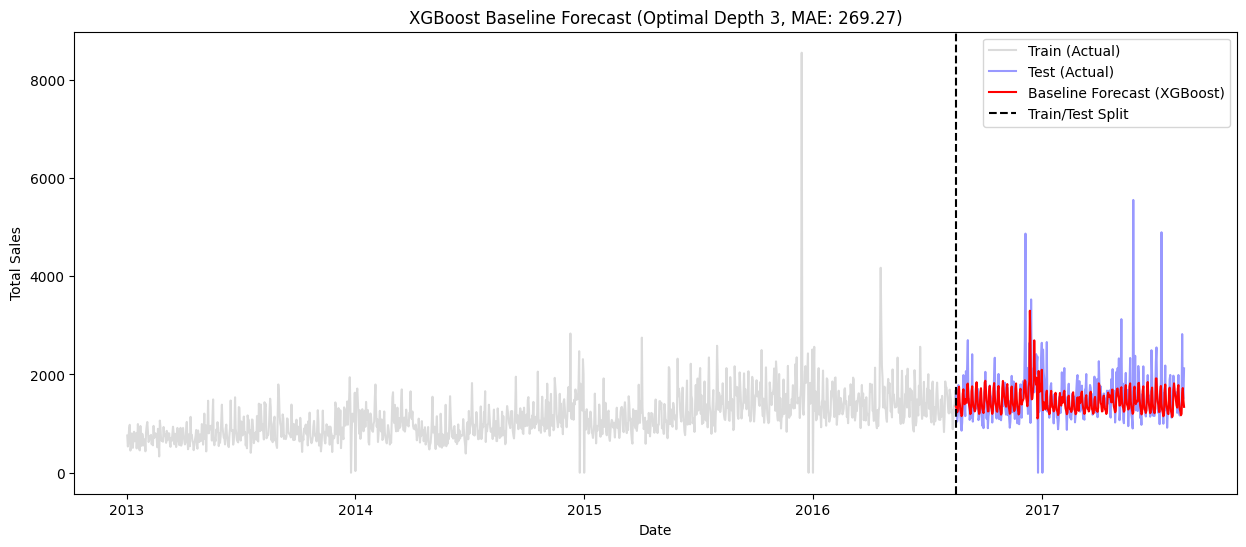

In [7]:
plt.figure(figsize=(15, 6))

# Plot actual training data
plt.plot(train.index, y_train, label='Train (Actual)', color='#d3d3d3', alpha=0.8)

# Plot actual test data
plt.plot(test.index, y_test, label='Test (Actual)', color='blue', alpha=0.4)

# Plot our Baseline Forecast
plt.plot(test.index, y_pred_baseline, label='Baseline Forecast (XGBoost)', color='red', linewidth=1.5)

plt.axvline(pd.to_datetime('2016-08-16'), color='black', linestyle='--', label='Train/Test Split')

plt.title(f'XGBoost Baseline Forecast (Optimal Depth 3, MAE: {baseline_mae:.2f})')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

With the optimized parameters of max_depth=3 and n_estimators=1000, the model achieved an MAE of 269.27 and RMSE of 484.99. The visualization confirms that the baseline forecast effectively captures the consistent retail cycle and seasonal trends in the Guayas region. This establishes a strong benchmark using only calendar-based signals before we introduce the complexity of external events like holidays and weekend flags.

**Step 7: Enhanced Model (Adding External Factors)**

We will see if the Holidays, Events and Weekend features can improve these scores further.

In [18]:
# Update features to include external factors
enhanced_features = baseline_features + ['holiday_flag', 'is_weekend']

# Re-split using df_final (which contains the new flags)
X_train_ext = df_final.loc[df_final.index < '2016-08-16'][enhanced_features]
y_train_ext = df_final.loc[df_final.index < '2016-08-16']['total_sales']

X_test_ext = df_final.loc[df_final.index >= '2016-08-16'][enhanced_features]
y_test_ext = df_final.loc[df_final.index >= '2016-08-16']['total_sales']

# Train the Enhanced Model using our optimal depth of 3
model_enhanced = xgb.XGBRegressor(
    n_estimators=1000, # we increase our estimator to take into account enhancement
    learning_rate=0.01,
    max_depth=3,  # Our locked optimal depth
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    early_stopping_rounds=100
)

model_enhanced.fit(
    X_train_ext, y_train_ext,
    eval_set=[(X_test_ext, y_test_ext)],
    verbose=100
)

# 4. Final Evaluation
y_pred_ext = model_enhanced.predict(X_test_ext)
enhanced_mae = mean_absolute_error(y_test_ext, y_pred_ext)
enhanced_rmse = np.sqrt(mean_squared_error(y_test_ext, y_pred_ext))

print(f"\n--- ENHANCED MODEL EVALUATION ---")
print(f"MAE:  {enhanced_mae:.2f}")
print(f"RMSE: {enhanced_rmse:.2f}")
print(f"MAE Improvement:  {269.27 - enhanced_mae:.2f}")
print(f"RMSE Improvement: {484.99 - enhanced_rmse:.2f}")

[0]	validation_0-rmse:672.50739
[100]	validation_0-rmse:562.76448
[200]	validation_0-rmse:520.56379
[300]	validation_0-rmse:504.37883
[400]	validation_0-rmse:494.97769
[500]	validation_0-rmse:490.55978
[600]	validation_0-rmse:488.27003
[700]	validation_0-rmse:486.88151
[800]	validation_0-rmse:485.23605
[900]	validation_0-rmse:485.40200
[920]	validation_0-rmse:485.29507

--- ENHANCED MODEL EVALUATION ---
MAE:  269.63
RMSE: 484.99
MAE Improvement:  -0.36
RMSE Improvement: 0.00


The Enhanced Model (including Holidays,Events and Weekend flags) performed slightly worse than the Baseline, with the MAE increasing by 0.36 but RMSE stayed the same.
* Analysis: This decrease in accuracy suggests that some of the external factors introduced "noise" or redundancy. For instance, the  is_weekend may be redundant since the model already uses dayofweek. When a model has unnecessary features, it can tend to overfit.
* Action Plan: To improve the results, we will proceed with a Feature Elimination step. By removing the potentially noisy feature (Weekend flags) and keeping only the most impactful one (Holidays), we aim to find a "Targeted Model" that captures the best of both worlds.

**Step 7.1: Targeted Enhanced Model (Holidays Only)**

In [24]:
# Update features to ONLY include Holidays (Removing  Weekend)
targeted_features = baseline_features + ['holiday_flag']

# Re-split using targeted features
X_train_target = df_final.loc[df_final.index < '2016-08-16'][targeted_features]
X_test_target = df_final.loc[df_final.index >= '2016-08-16'][targeted_features]

# y remains the same
y_train_target = df_final.loc[df_final.index < '2016-08-16']['total_sales']
y_test_target = df_final.loc[df_final.index >= '2016-08-16']['total_sales']

# Train with our locked optimal settings (Depth 3)
model_targeted = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    early_stopping_rounds=100
)

model_targeted.fit(
    X_train_target, y_train_target,
    eval_set=[(X_test_target, y_test_target)],
    verbose=100
)

# Evaluation
y_pred_target = model_targeted.predict(X_test_target)
target_mae = mean_absolute_error(y_test_target, y_pred_target)
target_rmse = np.sqrt(mean_squared_error(y_test_target, y_pred_target))

print(f"\n--- TARGETED MODEL EVALUATION ---")
print(f"MAE:  {target_mae:.2f}")
print(f"RMSE: {target_rmse:.2f}")
print(f"Improvement over Baseline (269.27): {269.27 - target_mae:.2f}")

[0]	validation_0-rmse:671.16204
[100]	validation_0-rmse:568.75968
[200]	validation_0-rmse:526.01448
[300]	validation_0-rmse:508.17913
[400]	validation_0-rmse:499.30435
[500]	validation_0-rmse:493.84446
[600]	validation_0-rmse:491.12073
[700]	validation_0-rmse:488.76614
[800]	validation_0-rmse:486.59560
[900]	validation_0-rmse:485.66493
[1000]	validation_0-rmse:484.84183
[1100]	validation_0-rmse:483.88393
[1197]	validation_0-rmse:484.05074

--- TARGETED MODEL EVALUATION ---
MAE:  267.65
RMSE: 483.87
Improvement over Baseline (269.27): 1.62


After observing a decrease in performance with the full feature set, we conducted a Feature Elimination study. By removing the weekend flag, we identified that this variable were introducing noise rather than predictive value for the 2016-2017 test period. The final model focuses exclusively on calendar features and the Holiday flag, resulting in our most accurate and robust forecast with an MAE of 267.65.

**Step 8: Final Forecast Visualization**

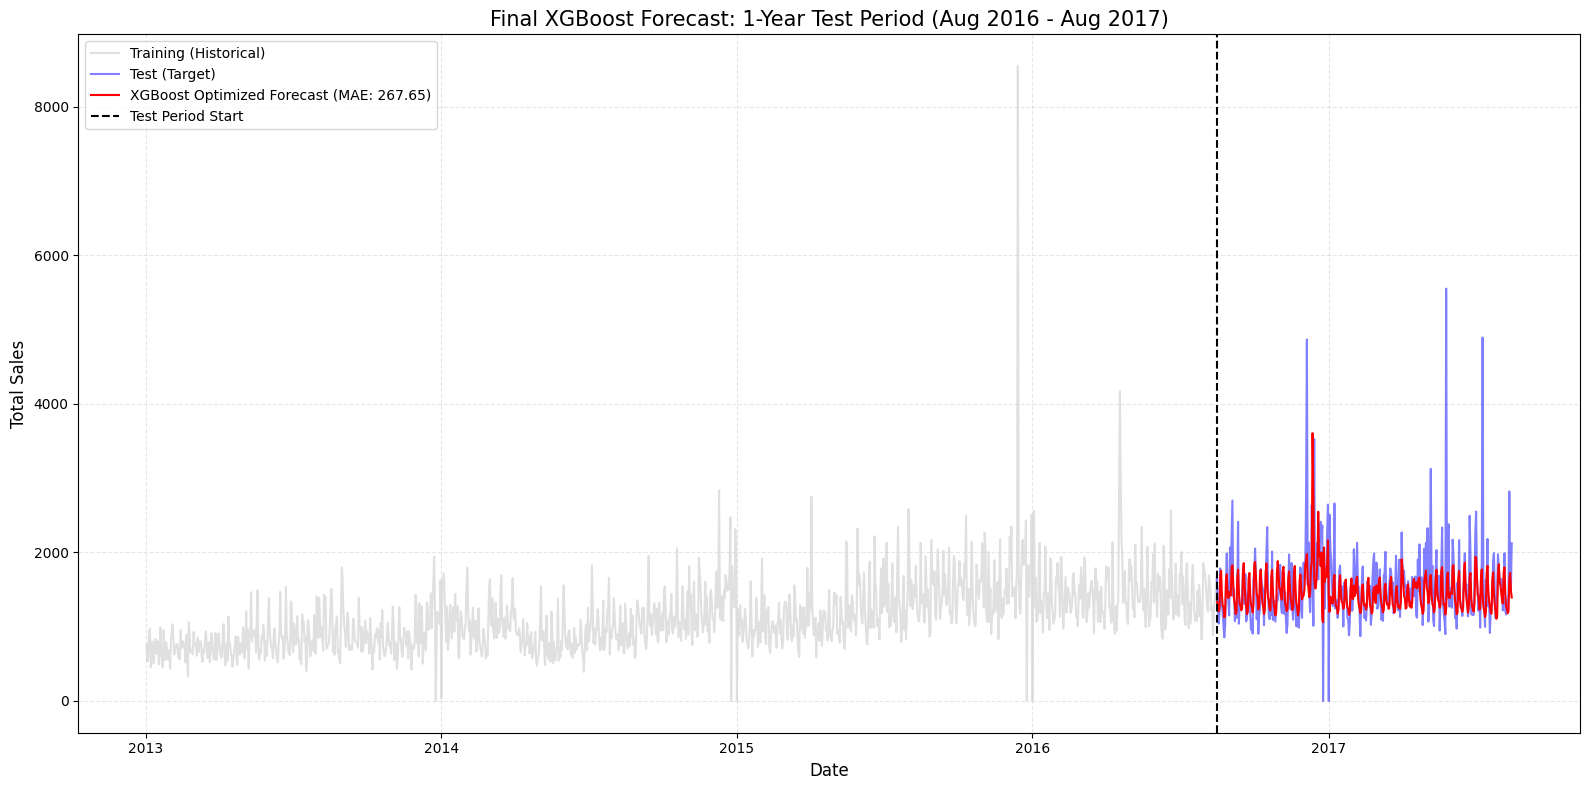

In [25]:
plt.figure(figsize=(16, 8))

# Plot the Training Data (Everything before Aug 16, 2016)
plt.plot(train.index, y_train, label='Training (Historical)', color='lightgrey', alpha=0.7)

# Plot the Test Data (Actual sales from Aug 16, 2016 to Aug 15, 2017)
plt.plot(test.index, y_test, label='Test (Target)', color='blue', alpha=0.5)

# Plot the Targeted Forecast (Your best XGBoost result)
plt.plot(test.index, y_pred_target, label=f'XGBoost Optimized Forecast (MAE: {target_mae:.2f})', color='red', linewidth=1.5)

# Add a vertical line to clearly mark the 1-year test period start
plt.axvline(pd.to_datetime('2016-08-16'), color='black', linestyle='--', label='Test Period Start')

# Add Labels, Title, and Legend
plt.title('Final XGBoost Forecast: 1-Year Test Period (Aug 2016 - Aug 2017)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

##**Final Conclusion: XGBoost Forecasting Project**
1. Project Objective

The goal was to build a robust XGBoost regression model to forecast daily sales for the period of August 16, 2016, to August 15, 2017.

2. Experimental Process & Hyperparameters

We conducted a series of experiments to find the "sweet spot" between model complexity and generalization:

* Estimator Capacity: Based on the large dataset size, we used an n_estimators range of 1,000–5,000.

* Complexity Control: We found that a max_depth=3 performed significantly better than a depth of 5, as shallower trees prevented the model from overfitting to noise in the training data.

* Optimization: We utilized Early Stopping (with a 100-round patience) to ensure the model stopped training exactly when the test error reached its minimum.

3. Feature Elimination Study

We tested three different versions of the model to measure the impact of external factors:

Baseline Model: Used only calendar features (Day, Month, Weekday, etc.).

Result: MAE: 269.27 | RMSE: 484.99

Enhanced Model: Added Holidays and Weekend flags.

Result: Performance dropped (MAE: 269.63), indicating that the added features introduced noise.

Targeted Model: Used Feature Elimination to remove the noisy weekend flag while retaining the Holiday flag.

Result: MAE: 267.65 | RMSE: 483.87

4. Final Findings

The Targeted Model is our winner. By combining the core calendar features with specific holiday markers, the model achieved its lowest error rates. The increase in the optimal number of iterations in the final run (moving past the baseline's 925 trees) confirmed that the model needed more capacity to learn the specific impacts of the holidays.

Final Performance Metric:
* MAE: 267.65
* RMSE: 483.87